In [5]:
# ----------------------------------------------
# Yolo Keras Hand Detection
# ----------------------------------------------

from datetime import datetime
import numpy as np
import sys, getopt
import cv2
import os
from keras import backend as K
import time

os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.models import load_model
from keras.preprocessing import image

from matplotlib import pyplot as plt

#YOLOV2
#reference from https://github.com/experiencor/keras-yolo2
# https://github.com/experiencor/keras-yolo2/blob/master/LICENSE


In [6]:
def interpret_output_yolov2(output, img_width, img_height):
	anchors=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

	netout=output
	nb_class=1
	obj_threshold=0.4
	nms_threshold=0.3

	grid_h, grid_w, nb_box = netout.shape[:3]

	size = 4 + nb_class + 1;
	nb_box=5

	netout=netout.reshape(grid_h,grid_w,nb_box,size)

	boxes = []
	
	# decode the output by the network
	netout[..., 4]  = _sigmoid(netout[..., 4])
	netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
	netout[..., 5:] *= netout[..., 5:] > obj_threshold

	for row in range(grid_h):
		for col in range(grid_w):
			for b in range(nb_box):
				# from 4th element onwards are confidence and class classes
				classes = netout[row,col,b,5:]
				
				if np.sum(classes) > 0:
					# first 4 elements are x, y, w, and h
					x, y, w, h = netout[row,col,b,:4]

					x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
					y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
					w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
					h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
					confidence = netout[row,col,b,4]
					
					box = bounding_box(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
					
					boxes.append(box)

	# suppress non-maximal boxes
	for c in range(nb_class):
		sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			
			if boxes[index_i].classes[c] == 0: 
				continue
			else:
				for j in range(i+1, len(sorted_indices)):
					index_j = sorted_indices[j]
					
					if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
						boxes[index_j].classes[c] = 0
						
	# remove the boxes which are less likely than a obj_threshold
	boxes = [box for box in boxes if box.get_score() > obj_threshold]
	
	result = []
	for i in range(len(boxes)):
		if(boxes[i].classes[0]==0):
			continue
		predicted_class = "hand"
		score = boxes[i].score
		result.append([predicted_class,(boxes[i].xmax+boxes[i].xmin)*img_width/2,(boxes[i].ymax+boxes[i].ymin)*img_height/2,(boxes[i].xmax-boxes[i].xmin)*img_width,(boxes[i].ymax-boxes[i].ymin)*img_height,score])

	return result

class bounding_box:
	def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		
		self.c     = c
		self.classes = classes

		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
		
		return self.label
	
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
			
		return self.score

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
	
	intersect = intersect_w * intersect_h

	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	
	union = w1*h1 + w2*h2 - intersect
	
	return float(intersect) / union

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b

	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3          

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
	x = x - np.max(x)
	
	if np.min(x) < t:
		x = x/np.min(x)*t
		
	e_x = np.exp(x)
	
	return e_x / e_x.sum(axis, keepdims=True)

#crop
def crop(x,y,w,h,margin,img_width,img_height):
	xmin = int(x-w*margin)
	xmax = int(x+w*margin)
	ymin = int(y-h*margin)
	ymax = int(y+h*margin)
	if xmin<0:
		xmin = 0
	if ymin<0:
		ymin = 0
	if xmax>img_width:
		xmax = img_width
	if ymax>img_height:
		ymax = img_height
	return xmin,xmax,ymin,ymax

#display result
def show_results(img,results, img_width, img_height):
	img_cp = img.copy()
	print('len results:',len(results))
	img_cp1 = cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB)
	for i in range(len(results)):
		x = int(results[i][1])
		y = int(results[i][2])
		w = int(results[i][3])//2
		h = int(results[i][4])//2

		xmin,xmax,ymin,ymax=crop(x,y,w,h,1.0,img_width,img_height)

		cv2.rectangle(img_cp1,(xmin,ymin),(xmax,ymax),(0,255,0), 30)
		cv2.rectangle(img_cp1,(xmin,ymin-20),(xmax,ymin),(125,125,125),-1)
		cv2.putText(img_cp1,results[i][0] + ' : %.2f' % results[i][5],(xmin+5,ymin-7),cv2.FONT_HERSHEY_SIMPLEX,7,(255,0, 0), 15 , cv2.LINE_AA)
	return img_cp1 #cv2.imshow('YoloKerasHandDetection',img_cp)


In [7]:
MODEL_ROOT_PATH="./pretrain/"

#Load Model
model_hand = load_model(MODEL_ROOT_PATH+'yolov2_tiny-hand.h5')

/root/team3/yes/envs/YoloKeras/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1591375501.2959576
prediction time: 0.11195969581604004
len results: 2


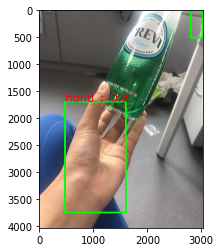

In [9]:

img=cv2.imread('./hand/5.jpg', cv2.IMREAD_COLOR)
img = img[...,::-1]  #BGR 2 RGB
inputs = img.copy() / 255.0

img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_camera = cv2.resize(inputs, (416,416))
img_camera = np.expand_dims(img_camera, axis=0)
start = time.time()
print(start)
out2 = model_hand.predict(img_camera)[0]
end = time.time()
print('prediction time:',end-start)
results = interpret_output_yolov2(out2, img.shape[1], img.shape[0])

#Age and Gender Detection
img_cp=show_results(img_cv,results, img.shape[1], img.shape[0])
plt.imshow(img_cp)
plt.imsave('save.png',img_cp)


In [11]:
from os import listdir
from os.path import isfile, join

target_dir = './hand'
files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

['8.jpg', '3.jpg', '5.jpg', '2.jpg', '1.jpg', 'wild_hand.jpg', '9.jpg', '4.jpg', '6.jpg', '7.jpg', 'wallet.jpg', 'wallet2.jpg']


In [12]:
def get_result(img_path,img_name, dst_dir):

  file_name = os.path.join(dst_dir,img_name[:-4]+'_result.png')
  img=cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = img[...,::-1]  #BGR 2 RGB
  inputs = img.copy() / 255.0
  
  img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img_camera = cv2.resize(inputs, (416,416))
  img_camera = np.expand_dims(img_camera, axis=0)
  start = time.time()
  out2 = model_hand.predict(img_camera)[0]
  end = time.time()
  print('prediction time:',end-start)
  start = time.time()
  results = interpret_output_yolov2(out2, img.shape[1], img.shape[0])
  end = time.time()
  print('interpret time:',end-start)

  #Age and Gender Detection
  img_cp=show_results(img_cv,results, img.shape[1], img.shape[0])
  plt.imshow(img_cp)
  print(file_name)
  plt.imsave(file_name,img_cp)

1591355632.6543417
prediction time: 0.09203529357910156
len results: 2
./result/5_result.png


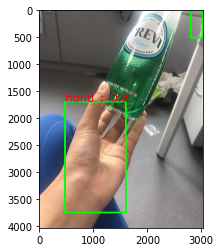

In [29]:
get_result('./hand/5.jpg','5.jpg','./result')

['8.jpg', '3.jpg', '5.jpg', '2.jpg', '1.jpg', 'wild_hand.jpg', '9.jpg', '4.jpg', '6.jpg', '7.jpg', 'wallet.jpg', 'wallet2.jpg']
prediction time: 0.0952141284942627
interpret time: 0.006537437438964844
len results: 0
./result/8_result.png
prediction time: 0.09984064102172852
interpret time: 0.007192134857177734
len results: 2
./result/3_result.png
prediction time: 0.09788680076599121
interpret time: 0.006998300552368164
len results: 2
./result/5_result.png
prediction time: 0.09572553634643555
interpret time: 0.0069620609283447266
len results: 1
./result/2_result.png
prediction time: 0.09241437911987305
interpret time: 0.006852388381958008
len results: 0
./result/1_result.png
prediction time: 0.0962224006652832
interpret time: 0.008185625076293945
len results: 1
./result/wild_hand_result.png
prediction time: 0.09573030471801758
interpret time: 0.0070037841796875
len results: 1
./result/9_result.png
prediction time: 0.09176778793334961
interpret time: 0.00709986686706543
len results: 2
./

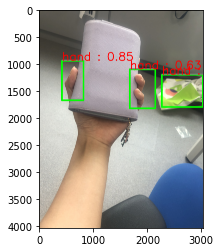

In [13]:
# img_path,img_name, dst_dir

target_dir = './hand'
dst_dir = './result'
files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

for i in files:
   file_name = os.path.join(target_dir,i)
   get_result(file_name, i,dst_dir )